# Cogs 108 - Final Project

# Overview

In this project I wanted to find the correlation between yelp reviews of parks in San Diego and the number of police incident calls. From the analysis I found zero correclation between the average park ratings by area and the number of police calls for that area.

# Name and Github
* Name: Phuc Dao
* Github Username: Phuc-Dao

# Research Question
What is the relationship between the average yelp review of parks in San Diego and the number of police calls in that area?

# Background and Prior Work

There have been many studies that show the benefits of having a park near a neighborhood such as a healthier and overall happier population. Strong evidence suggest that high-quality green spaces in residential enviorments promote public health. Howeever one one the largest barrier to park usage is crime and fear of crime, especially since some people see parks as a magnet for criminal activities. This is even worse in areas where parks are seen as deteriorated or not renovated, and get less people visiting them. In order to verify if areas with parks that are not renovated does indeed see more crime rate I will be doing analysis using yelp reviews of parks in San Diego and data on police calls.

Reference
* [Effects of Crime Type and Location on Park Use Behavior](https://www.cdc.gov/pcd/issues/2020/19_0434.htm)
* [Violent Crime and Park Use in Low-Income Urban Neighborhoods](https://pubmed.ncbi.nlm.nih.gov/29338953/)
* [Can Parks help cities fight crime?](https://theconversation.com/can-parks-help-cities-fight-crime-118322#:~:text=Examining%20four%20cities%20in%20different,in%20areas%20close%20to%20parks.)
* [Why Are Parks Important](https://www.brec.org/index.cfm/page/1808/n/153#:~:text=Parks%20provide%20intrinsic%20environmental%2C%20aesthetic,and%20workers%2C%20and%20attract%20retirees.)
* [The Benefits of Parks: Why America Needs More City Parks and Open Spaces](https://conservationtools.org/library_items/729-the-benefits-of-parks-why-america-needs-more-city-parks-and-open-space)

# Hypothesis
I hypothesize that there will be no correlation between parks with lower reviews on yelp and the number of police calls in the area. There are many factors that contribute to crime rate in an area and a park is not one of the reasons why. I predict that we will see parks with really high ratings and really high police calls as well as parks with really low ratings and low police calls as well.

# Dataset(s)
The ideal dataset for the parks would include the number of people that visit that park, the reviews on yelp, the number of reviews, and the area that the park is located in. The ideal dataset for the police calls would include what type of call it was (ie what kind of offense) the area the call was in, and the date and time it was called in.

The Dataset that I will be using in my analysis was provided by the professor. Of the different datasets i will be using the two datasets
* pd_calls_for_service_2020_datasd.csv
* yelp_SD_reviews.csv

The first dataset contains 429304 obsercation and it contains the id of the police call, the data and time, the priority of the call, the street address, and the call type (i.e domestic violence, firearms etc)

The second dataset contains 2334 observatiosn and conatins the Park name, park location, yelp review, and the most previous review comment left by the reviewer

I will merge these two datasets by first taking the average park reviews by different areas, and then count the number of incidents for that area in the police data set

# Setup

In [96]:
import seaborn as sns
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [97]:
df_police = pd.read_csv("../data/pd_calls_for_service_2020_datasd.csv")
df_parks = pd.read_csv("../data/yelp_SD_parks.csv")


# Data Cleaning

I had to get the general area of each park. Since the data set came with the entire street address I parsed the location. For exmaple 8958 Clairemont RD San Diego, CA 92123 would become Clairemont RD. I also only looked at parks in San Diego

In [98]:
def clean_address(string):
    """
    cleans the data of the street adress by getting rid the zipcode and building number/suite if it has any
    """
    string_lower = string.lower()
    # Only look in san diego
    if string_lower.find("san diego") == -1 or string_lower.find(" and ") != -1 or string_lower.find(" & ") != -1:
        return np.nan
    # Remove the street address if it has one
    prefix = string_lower.split(" ")[0]
    if prefix.isnumeric() or "-" in prefix:
        string_lower = string_lower.split(" ", 1)[1]

    # remove san diego, ca 9xxxx
    string_lower = string_lower[0: string_lower.find("san diego, ca")]
    
    # Remove Suit or building number
    street_type = [" blvd", " ave", " way", " rd", " st", " dr"]
    for s in street_type:
        if s in string_lower:
            string_lower = string_lower[:string_lower.find(s) + len(s)]
    return string_lower

df_parks['area'] = df_parks['address'].apply(lambda row: clean_address(row))


This helper method was needed because the police data was not consistent with how the used BLVD. Some times they would use BLVD and othertimes they would use BLV

In [99]:
def clean_blvd(suffix):
    if suffix is np.nan:
        return ""
    if suffix.strip() is "BLV":
        return "BLVD"
    else:
        return suffix

# df_police = df_police[(df_police.call_type == "245") | (df_police.call_type == "245R") | (df_police.call_type == "245-SUSP") | (df_police.call_type == "AU245")]
df_police['address_sfx_primary'] = df_police['address_sfx_primary'].apply(lambda row: clean_blvd(row))

Renamed some of the columns in the police to be more readable

In [100]:
# Rename police columns
df_police.rename(columns={df_police.columns[0]: 'inc', df_police.columns[5]: 'road', df_police.columns[6]: 'suffix'}, inplace=True)
# Drop unused columns from df_parks
df_parks = df_parks.drop(columns=['phone', 'longitude', 'latitude', 'is_closed', 'id', 'url', 'phone'])

In [101]:
df_police

,inc,date_time,day_of_week,address_number_primary,address_dir_primary,road,suffix,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E20010000001,2020-01-01 00:00:09,4,400,NaN,06TH,AVE,NaN,NaN,NaN,11-8,A,523.0,0.0
1,E20010000002,2020-01-01 00:00:20,4,5000,NaN,UNIVERSITY,AVE,NaN,NaN,NaN,FD,K,826.0,2.0
2,E20010000003,2020-01-01 00:00:21,4,800,NaN,SAWTELLE,AVE,NaN,NaN,NaN,AU1,W,434.0,1.0
3,E20010000004,2020-01-01 00:00:32,4,5000,NaN,UNIVERSITY,AVE,NaN,NaN,NaN,FD,K,826.0,2.0
4,E20010000005,2020-01-01 00:00:42,4,5200,NaN,CLAIREMONT MESA,BLV,NaN,NaN,NaN,415V,K,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429299,E20100003085,2020-10-02 16:41:54,6,0,NaN,CAVE,ST,NaN,PROSPECT PL,NaN,HZRD,O,124.0,1.0
429300,E20100003086,2020-10-02 16:42:05,6,1600,NaN,EUCLID,AVE,NaN,NaN,NaN,415,K,451.0,2.0
429301,E20100003087,2020-10-02 16:42:57,6,9000,NaN,WOODLAWN,DR,NaN,NaN,NaN,459A,CAN,242.0,2.0
429302,E20100003088,2020-10-02 16:44:33,6,0,NaN,41ST,ST,NaN,MARKET,NaN,5150,K,444.0,2.0


Did the same thing with the police data to get the general location of the police call from the exact address. Also created a new df named inc_count_df which contained the count of all the incident calls by area

In [102]:
# Create a new table with the count of police calls

def get_full_addr(road, suffix):
    """
    Combines the address road primary and the road sfx
    """
    pre = "" if road is np.nan else road.strip()
    suf = "" if suffix is np.nan else suffix.strip()

    # Converts BLV to BLVD
    if suf == 'BLV':
        suf = 'BLVD'
    
    # remove leading 0
    if len(pre) > 0 and pre[0] is "0":
        pre = pre[1:]
    full_addr = pre + " " + suf
    full_addr = full_addr.strip()
    return full_addr.lower()
    
df_police['full_addr'] = df_police.apply(lambda row: get_full_addr(row['road'], row['suffix']), axis=1)

In [103]:

inc_count_df = df_police['full_addr'].value_counts()
inc_count_df

imperial ave          7473
el cajon blvd         7303
university ave        6949
5th ave               5307
broadway              4390
                      ... 
roxbury rd               1
sencillo ct              1
schraer 671q             1
- sgt zingheim           1
sunflower crest pl       1
Name: full_addr, Length: 10767, dtype: int64

merged inc_count_df and df_police by there general area to create merged df

In [104]:
def foo(x, inc_count_df):
    query = inc_count_df.get(x)
    query = 0 if not query else query
    return query

# Merge the two dataframes into one single one
merged_df = df_parks.groupby('area').mean()
merged_df['inc_count'] = merged_df.index.map(lambda x : foo(x, inc_count_df))
merged_df['area'] = merged_df.index.map(lambda x : x)

In [105]:
merged_df

,rating,review_count,inc_count,area
area,,,,
,4.308824,24.176471,76,
1/2 india st,5.000000,4.000000,0,1/2 india st
13th st,3.000000,9.000000,1007,13th st
1407a shelter island dr,5.000000,1.000000,0,1407a shelter island dr
14th st,3.500000,34.000000,1719,14th st
...,...,...,...,...
wickerbay cv,4.500000,9.000000,0,wickerbay cv
wightman st,4.000000,1.000000,618,wightman st
willow creek rd,4.000000,5.000000,28,willow creek rd


In [106]:
merged_df[merged_df.inc_count > 0].sort_values(by=['rating'], ascending=True).head(20)

,rating,review_count,inc_count,area
area,,,,
elm st,1.000,1.0,273,elm st
twin trails dr,1.000,1.0,151,twin trails dr
54th st,1.000,2.0,1441,54th st
krenz st,1.500,25.0,4,krenz st
pavlov ave,1.500,8.0,25,pavlov ave
rigel st,1.500,3.0,129,rigel st
cargill ave,1.500,16.0,34,cargill ave
grove ave,2.000,1.0,124,grove ave
gill village way,2.000,133.0,69,gill village way


# Data Analysis and Visualization


First I wanted to visulize the distribution of my data so I plotted histograms of the incident count and the average rating from the merged df. From the visualization it seems that the majority of ratings are 3.5 or above and the majority of incident counts are zero

Text(0.5, 0, 'incident count')

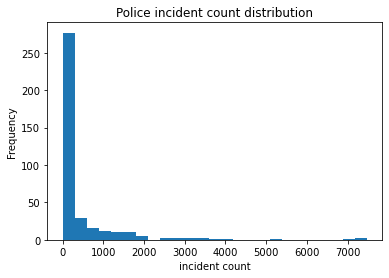

In [107]:
sn = merged_df['inc_count'].plot(kind='hist', bins=25, title='Police incident count distribution')
sn.set_xlabel('incident count')

Text(0.5, 0, 'Average rating')

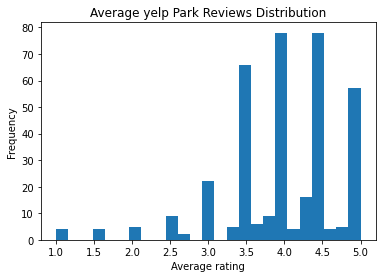

In [108]:
sn = merged_df['rating'].plot(kind='hist', bins=25, title='Average yelp Park Reviews Distribution')
sn.set_xlabel('Average rating')


In [109]:
# Generate plot with differnt call types
def create_df_list(df, df_parks):
    call_types = df.call_type.unique()
    df_list = []
    for ct in call_types:
        inc_count_df = df[df.call_type == ct]['full_addr'].value_counts()
        merged_df = df_parks.groupby('area').mean()
        merged_df['inc_count'] = merged_df.index.map(lambda x : foo(x, inc_count_df))
        merged_df['area'] = merged_df.index.map(lambda x : x)
        df_list.append((merged_df, ct))
    return df_list
    
police_df_list = create_df_list(df_police, df_parks)

I wanted to visualize the average rating and the incident count together so I decided to use a scatter plot with the independent variable being the average review and the dependent variable being the incident count. Since the dataset splits up the incident calls by types (ie manslaughter, drugs, and assault) I created different scatter plots for each different incident type

In [110]:
merged_df_by_inc_type = []
title_map = {'245R': 'Assault', '1130': 'Manslaughter', '1016': 'Drug' }

for e in police_df_list:
    title = "" if e[1] is np.nan else e[1]
    if title in title_map:
        merged_df_by_inc_type.append(e)

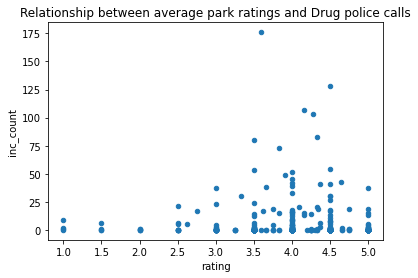

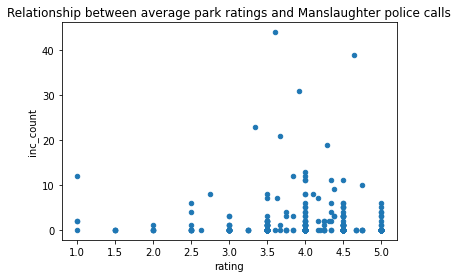

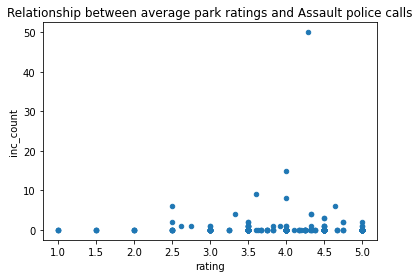

In [111]:
for e in merged_df_by_inc_type:
    e[0].plot.scatter(x='rating', y='inc_count', title='Relationship between average park ratings and {} police calls'.format(title_map[e[1]]))
    

In [112]:
## Linear Regression

To see if there is a correlation between average rating and incident count I used linear regression to draw a regression line for the three different types of Police Calls. 

In [119]:
title_map = {'245R': 'Assault', '1130': 'Manslaughter', '1016': 'Drug' }

for e in merged_df_by_inc_type:
    outcome, predictors = patsy.dmatrices('inc_count ~ rating', e[0])
    mod = sm.OLS(outcome, predictors)
    res = mod.fit()
    print(res.summary())
    

                            OLS Regression Results                            
Dep. Variable:              inc_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.05289
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.818
Time:                        23:58:20   Log-Likelihood:                -1601.2
No. Observations:                 374   AIC:                             3206.
Df Residuals:                     372   BIC:                             3214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8189      4.713      1.023      0.3

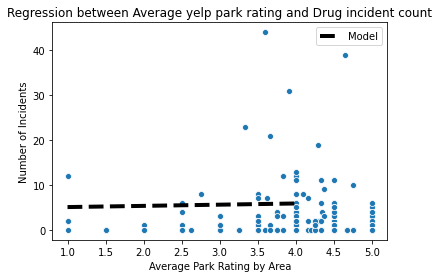

In [141]:
sns.scatterplot(x='rating',y='inc_count', data=merged_df_by_inc_type[1][0])
xs = np.arange(merged_df_by_inc_type[1][0]['rating'].min(), merged_df_by_inc_type[1][0]['rating'].max())
ys = 0.2665 * xs + 4.8189 

plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.xlabel('Average Park Rating by Area')
plt.ylabel('Number of Incidents')
inc_type = title_map[merged_df_by_inc_type[0][1]]
plt.title('Regression between Average yelp park rating and {} incident count'.format(inc_type))
plt.legend();


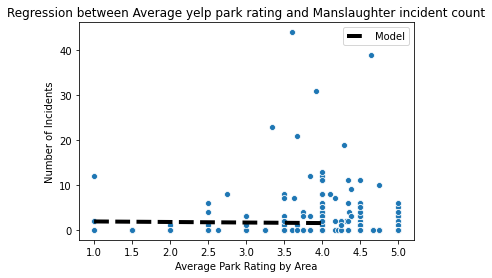

In [142]:
sns.scatterplot(x='rating',y='inc_count', data=merged_df_by_inc_type[1][0])
xs = np.arange(merged_df_by_inc_type[1][0]['rating'].min(), merged_df_by_inc_type[1][0]['rating'].max())
ys = -0.1197 * xs + 2.0042 
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.xlabel('Average Park Rating by Area')
plt.ylabel('Number of Incidents')
inc_type = title_map[merged_df_by_inc_type[1][1]]
plt.title('Regression between Average yelp park rating and {} incident count'.format(inc_type))
plt.legend();


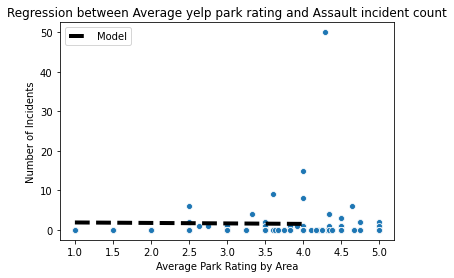

In [143]:
sns.scatterplot(x='rating',y='inc_count', data=merged_df_by_inc_type[2][0])
xs = np.arange(merged_df_by_inc_type[2][0]['rating'].min(), merged_df_by_inc_type[2][0]['rating'].max())
ys = -0.1197 * xs + 2.0042 
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.xlabel('Average Park Rating by Area')
plt.ylabel('Number of Incidents')
inc_type = title_map[merged_df_by_inc_type[2][1]]
plt.title('Regression between Average yelp park rating and {} incident count'.format(inc_type))
plt.legend();

# Ethics and Privacy 
Since this data was provided to me I had coplete permission to use this data for this prupose. 

There are no privacy concerns regarding the dataset because it is all public data that is anonomyzed. No persons name or personal information was given out in these data sets.

There are potential biases in my dataset regarding certain communities. For example the data set might expose that some general area might have a higher crime-rate which might lead to biases of people wanting to go to those areas. A possible unintended consequence of this analysis could be a decrease in people wanting to go to parks in areas where there might be higher rates of crimes.


# Conclusion and Discussion
The question I had at the beginning of this project was whether or not parks with bad reviews and crime rates were related. In my analysis I used two data sets one that had data on review of parks in san diego and the other had police calls in 2020. I seperated the parks in the first data set by general location and then I had the average review for each general area. Then I merged the new dataframe with the average review with the number of police calls by area. I then used simple linear regression to determine if there was any correlation between the the average review and the incident count. For each of the types of incidents, Assault, Manslaughter, and Drugs I did not find any corerelation between the average park ratings and the number of incident count which supports my original hypothesis.

One limitation to this project was that the data was used strictly in San Diego. These results might be wildly different depending on the geolocation of the city. Another limitation is that the review of parks might be skewed by the number of reviewers. For example a park that is really good might have a single person put a bad review and that might cause the data to not be accurate. Also I am not sure what the year of the reviews in the yelp dataset. But parks that recently opened up might not be as established as older parks depending on the year the park opened up. There are also limitations in the technique I used for analysis. I used simple linear regression but there might be other methods that are more accurate but I could not get to due to the time constraint.

This project can potentially have many positive impacts on society. First it promotes park safety and attempts to get more people to use parks, this results in an overall healthier and happier population. It also allow for more parks to be built by disproving the idea that crime activity occur more often near parks.